# System Workflow

![Screenshot](./Snapshots/flow_diagram.png)

## Step-1 :
## Load the Youtube Transcripts based on TimeStamp Chunks

In [1]:
from langchain_community.document_loaders import YoutubeLoader # Load the Youtube Transcript
from langchain_community.document_loaders.youtube import TranscriptFormat # To Get transcripts as timestamped chunks
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
try:
    loader = YoutubeLoader.from_youtube_url(
        "https://www.youtube.com/watch?v=LLEc_fqEk_k&t=1554s",
         language=["hi"],
         translation="en",
        transcript_format=TranscriptFormat.CHUNKS,
        chunk_size_seconds=60,
    )
    docs = loader.load()

    if docs:
        print(f"Successfully loaded {len(docs)} transcript chunks")
    else:
        print("No transcript data was loaded (empty result)")

except Exception as e:
    print(f"Error loading YouTube transcript: {str(e)}")
    docs = None  

if docs:
    pass
else:
    print("Failed to load transcript, cannot proceed")

Successfully loaded 60 transcript chunks


In [3]:
len(docs)

60

In [4]:
docs[0]

Document(metadata={'source': 'https://www.youtube.com/watch?v=LLEc_fqEk_k&t=0s', 'start_seconds': 0, 'start_timestamp': '00:00:00'}, page_content="Tarak Mehta Ka Ooltah Chashma Papa it is getting very late.  Brother brother brother brother tapora show the report cut wait hey. Ke papa's stop the knife, hey stop if not then Jetha ji hi baba oh")

In [5]:
docs[2]

Document(metadata={'source': 'https://www.youtube.com/watch?v=LLEc_fqEk_k&t=120s', 'start_seconds': 120, 'start_timestamp': '00:02:00'}, page_content="don't forget to have tea and breakfast before leaving.  If they go to the shop like this, then on an empty stomach, Natu Kaka, Baka Bhai and whoever they meet will keep on feeding them Badka the whole day. Yes brother, yes I am coming, go inside now. Yes Babita ji bye bye. And Babita ji, where are you jogging?  Yes.  By the way Jetha ji, you should also start regular jogging. Look, you ran so much and you were so half-fed.  Meaning you have no stamina at all.  If you do regular jogging then you will see that gradually your stamina will build up like this.  No, definitely, definitely.  I was going to start jogging in a day or two anyway. And I was going to ask you the secret of staying fit and healthy, which herbal thing do you eat? From the first time I saw you till today, you look the same.")

In [6]:
index= 0
print(docs[index].metadata)
print(docs[index].page_content)

{'source': 'https://www.youtube.com/watch?v=LLEc_fqEk_k&t=0s', 'start_seconds': 0, 'start_timestamp': '00:00:00'}
Tarak Mehta Ka Ooltah Chashma Papa it is getting very late.  Brother brother brother brother tapora show the report cut wait hey. Ke papa's stop the knife, hey stop if not then Jetha ji hi baba oh


## Step-2
## Loading the embedding model and the llm

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

In [8]:
embedding_model = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from transformers import AutoTokenizer
# Initialize a llm model
# repo_id = "mistralai/Mistral-7B-Instruct-v0.3"
# # First load the tokenizer explicitly
# tokenizer = AutoTokenizer.from_pretrained(repo_id)
# llm1 = HuggingFaceEndpoint(
#     repo_id = repo_id,
#     temperature = 0.8,
#     max_new_tokens=500,
# )
# llm = ChatHuggingFace(llm=llm1,tokenizer=tokenizer)

c:\Users\Prabal Kuinkel\Desktop\Youtube-Conversational_AI\youtube_ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# !pip install langchain_groq

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name = "Qwen-Qwq-32b",max_tokens= 1000)

## Step-3
 
 ## Creating a vectordatabase using the Chroma db


In [11]:
# vector_store = FAISS.from_documents(docs, embedding_model)
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(docs, embedding_model)

In [12]:
# !pip install langchain-chroma
# !pip install lark

## Step-4 Defining the retriever
## Using the Metadatabased Filtering for retrievers

#### -> this retriever is known as self-query retriever

In [13]:
print(docs[index].metadata)

{'source': 'https://www.youtube.com/watch?v=LLEc_fqEk_k&t=0s', 'start_seconds': 0, 'start_timestamp': '00:00:00'}


In [14]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The link of the video",
        type="string"
    ),
    AttributeInfo(
        name="start_seconds",
        description="The starting second of the video chunk (in seconds as integer)",
        type="integer"  # Changed from string to integer
    ),
    AttributeInfo(
        name="start_timestamp",
        description="Human-readable timestamp (HH:MM:SS format)",
        type="string"
    )
]

In [15]:
# # First get the base retriever from your vectorstore with increased k
# base_vectorstore_retriever = vectorstore.as_retriever(
#     # search_type = "mmr",
#     search_kwargs={"k": 20,'lambda_mult':0.5}  # Increase this number as needed
# )

In [16]:
document_content_description = "Transcript of a youtube video"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
    # base_retriever = base_vectorstore_retriever,
    verbose=True,
    search_kwargs={"k": 5}  # Increase this number as needed

)

In [17]:
# This example only specifies a filter
# retriever.invoke("Create me a blog post about the video.")
# retriever.invoke("what is meant by multi query retriever ?")

## Step- 5 Creating tools

### Tool A. VectorStore Retriever tool (Convert the rag_chain into a tool)
Redirect to this tool if the user queries is regarding the Video content

### Tool B. DuckDuckSeach Tool
Redirect to this tool if the user query is general

In [18]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun #Search user queries Online

@tool
def retriever_vectorstore_tool(query:str)->str:
    """Use this tool when the user ask about:
    - content of the youtube video
    - Any queries specifically about the youtube video
    Input should be the exact search query.
    The tool will perform a vectorstore search using retriever."""
    return retriever.invoke(query)



search = DuckDuckGoSearchRun()
@tool
def duckducksearch_tool(query: str) -> str:
    """Use this tool when:
    - The question is not about youtube video
    
    Input should be the exact search query.
    The tool will perform a web search using DuckDuckGo.
    """
    return search.invoke(query)

## Step-6 Binding the llm with the tools

In [19]:
tools= [retriever_vectorstore_tool,duckducksearch_tool]
llm_with_tools=llm.bind_tools(tools=tools)

## Step-7 Define the langgraph workflow with memory

### Step-7.1 Define the State (flow of information through nodes)

In [ ]:
from typing_extensions import Annotated, TypedDict 
from typing import List 
from langchain_core.messages import AnyMessage #can be either HumanMsg or AImsg or ToolMsg
from langgraph.graph.message import add_messages #Append the new messages insted of replacing

class State(TypedDict):
    """Represents the state of our graph"""
    messages:Annotated[List[AnyMessage],add_messages]

### Step-7.2 Define the Graph

In [ ]:
from langgraph.graph import StateGraph, START, END
 # ToolNode is pre-built component that will invoke/execute the tool in behalf of the user and returns the tool_response
 # tools_condition is pre-built component that routes to ToolNode if the last message has tool call , otherwise routes to end
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display #to visualize the Graph

#### Step- 7.2.1 
#### Implement a ConversationalWindowBuffer Memory using langgraph

In [ ]:
# A function that determines the best tool to server the user query 
def tool_calling_llm(State:State)->State:
    return {'messages':llm_with_tools.invoke(State['messages'])}

In [36]:
tool_node = ToolNode(tools=tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'retriever_vectorstore_tool': StructuredTool(name='retriever_vectorstore_tool', description='Use this tool when the user ask about:\n    - content of the youtube video\n    - Any queries specifically about the youtube video\n    Input should be the exact search query.\n    The tool will perform a vectorstore search using retriever.', args_schema=<class 'langchain_core.utils.pydantic.retriever_vectorstore_tool'>, func=<function retriever_vectorstore_tool at 0x0000018497A58FE0>), 'duckducksearch_tool': StructuredTool(name='duckducksearch_tool', description='Use this tool when:\n    - The question is not about youtube video\n\n    Input should be the exact search query.\n    The tool will perform a web search using DuckDuckGo.', args_schema=<class 'langchain_core.utils.pydantic.duckducksearch_tool'>, func=<function duckducksearch_tool at 0x000001849

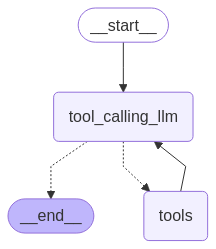

In [37]:
#Initializing the StateGraph
builder = StateGraph(state_schema=State)


#Adding the nodes
builder.add_node('tool_calling_llm',tool_calling_llm) # returns the tools that is to be used
builder.add_node('tools',tool_node) # Executes the specified tool

#Adding Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    # If the latest message from AI is a tool call -> tools_condition routes to tools
    # If the latest message from AI is a not a tool call -> tools_condition routes to LLM, then generate final response and END
    tools_condition
)
builder.add_edge('tools','tool_calling_llm')

#Compile the graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))



### Code Explaination / Flow :

    1. Starts with calling the 'tool_calling_llm' , which decides which tool is to be used to answer the user query .

    2. It is redirected to the 'tools_condition' function , where 
        
        Case I: If the Last 'AI Message' is a tool call ,then 'tools_conditions' automatically routes to 'tool_node' which will executes the specified tool and return the tool_response.

        Case II: If the last 'AI Message' is not a tool call, then 'tools_conditions' routes to 'tool_calling_llm' generates the final reponse and route to END


In [38]:
response = graph.invoke({
    'messages':"What happened between minute 10 to 16 according to video?"
})

In [26]:
# retriever.invoke("What are the names of footballers, mentioned according to the video , and can you also provide me the source/link of the video?")

In [27]:
# retriever.invoke("Who scored the goals according")

In [39]:
response

{'messages': [HumanMessage(content='What happened between minute 10 to 16 according to video?', additional_kwargs={}, response_metadata={}, id='23518801-770c-4063-bd0f-360bae6c8f3c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aqvy', 'function': {'arguments': '{"query": "What happened between minute 10 to 16 according to video?"}', 'name': 'retriever_vectorstore_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 303, 'total_tokens': 541, 'completion_time': 0.581416711, 'prompt_time': 0.017350453, 'queue_time': 0.491761932, 'total_time': 0.598767164}, 'model_name': 'Qwen-Qwq-32b', 'system_fingerprint': 'fp_3796682456', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8b1bb219-a78d-498a-aba3-5cff21340bdd-0', tool_calls=[{'name': 'retriever_vectorstore_tool', 'args': {'query': 'What happened between minute 10 to 16 according to video?'}, 'id': 'call_aqvy', 'type': 'tool_call'}], usage_metadata={

In [40]:
print(response['messages'][-1].content)